In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_acc(est_vad, est_blk_val, tgt_blk_val, tol=5, vad_th=0.6):
    n_blocks = len(est_vad)
    non_vad_blks,failed_frames_180_theta =[],[]
    acc=0
    valid_blk_count = 0
    for idx in range(0, n_blocks):
        if est_vad[idx] >=vad_th:
            if (np.abs(est_blk_val[idx] - np.abs(tgt_blk_val[idx])) <= tol):
                acc += 1
            else:
                if (np.abs(est_blk_val[idx] - (180-np.abs(tgt_blk_val[idx]))) <= tol):
                    failed_frames_180_theta.append(idx)
            valid_blk_count +=1
        else:
            non_vad_blks.append(idx)

    acc /= valid_blk_count
    
    #print(f'n_blocks: {n_blocks}, non_vad_blks: {non_vad_blks}')
    return acc, failed_frames_180_theta

In [3]:
def get_mag_ph(x):
    #est.shape : (batch, n_ch, T, F)
    (batch, n_ch, T, F) = x.shape
    eps = 1e-8
    est_mag_1 = torch.sqrt(x[0,0]**2 + x[0,1]**2 + eps)
    est_mag_2 = torch.sqrt(x[1,0]**2 + x[1,1]**2 + eps)

    est_ph_1 = torch.atan2(x[0,1,:,1:F-1] + eps, x[0,0,:,1:F-1] + eps)
    est_ph_2 = torch.atan2(x[1,1,:,1:F-1] + eps, x[1,0,:,1:F-1] + eps)

    return est_mag_1, est_ph_1, est_mag_2, est_ph_2

In [4]:

local_mic_pos = np.array((( -0.04,  0.000, 0.000),
                    (  0.04,  0.000, 0.000))) 

local_mic_center=torch.from_numpy(np.array([0.0, 0.0, 0.0]))

In [5]:
def gcc_phat_loc_orient(X, est_mask, fs, nfft, local_mic_pos, mic_center, src_mic_dist, weighted, sig_vad, is_euclidean_dist):

    (chan, frames, freq) = X.shape
    X_ph = torch.angle(X)
    X_ph_diff = X_ph[0,:,:] - X_ph[1,:,:]

    #weightage
    if weighted:
        est_mask_pq = torch.pow(est_mask[0,:,:]*est_mask[1,:,:], 1) #0.3)


    angular_freq = 2*torch.pi*fs*1.0/nfft*torch.arange(0, freq, dtype=torch.float32)

    angle_step = 1.0
    theta_grid = 180.0
    all_directions = torch.linspace(0,theta_grid,int(theta_grid/angle_step+1),dtype=torch.float32) #a set of potential directions
    dist = src_mic_dist
    c = 343

    all_directions_val = [] 
    delays = []
    all_info = []

    for ind, direction in enumerate(all_directions):
        #ang = (direction - 90)/180.0*torch.pi  #radians
        ang_doa  = (direction)/theta_grid*torch.pi  #radians
        
        if is_euclidean_dist:
            src_pos = torch.tensor([torch.cos(ang_doa)*dist,torch.sin(ang_doa)*dist, 0.0],dtype=torch.float32) #+ mic_center
            dist_pp = torch.sqrt(torch.sum((src_pos-local_mic_pos[0])**2))  ## TODO: pp
            dist_qq = torch.sqrt(torch.sum((src_pos-local_mic_pos[1])**2))  ## TODO: qq
            delay = (dist_qq-dist_pp)/c #,device=est_mask.device)#.type_as(est_mask)   

        else:
            # ASSUMPTION on unit circle
            dist = 1
            src_pos = torch.tensor([torch.cos(ang_doa)*dist,torch.sin(ang_doa)*dist, 0.0],dtype=torch.float32) 
            delay = np.dot((local_mic_pos[0]-local_mic_pos[1]), src_pos)/c

            
        delays.append(delay)
        delay_vec = angular_freq*delay
        #print(X_ph_diff.shape, delay_vec.shape)
        gcc_phat_pq = torch.cos( X_ph_diff - delay_vec.to(device=X_ph_diff.device))
        if weighted:
            mgcc_phat_pq = est_mask_pq*gcc_phat_pq
            gcc_phat_pq = mgcc_phat_pq

        all_info.append(gcc_phat_pq)
        per_direction_val = torch.sum(gcc_phat_pq, dim=1)

        all_directions_val.append(per_direction_val)

    vals = torch.stack(all_directions_val, dim=0)

    sig_vad_frms = sig_vad.shape[0]
    vals = vals[:,:sig_vad_frms]*sig_vad   ##caluation for only vad frames

    utt_sum = torch.sum(vals,dim=1)
    utt_doa_idx = torch.argmax(utt_sum)
    utt_doa = all_directions[utt_doa_idx]


    doa_idx = torch.argmax(vals,dim=0)
    doa = all_directions[doa_idx]

    return doa, vals, utt_doa, utt_sum, all_info#delays


#Vad 
#input: numpy signal
#output: torch signal
def compute_vad(source_signal: 'Array ( sig_len)', frame_size: 'int (samples) ', frame_shift: 'int (samples)', fs: int = 16000):
    import webrtcvad
    vad = webrtcvad.Vad()
    agressiveness=3
    vad.set_mode(agressiveness)

    #sig_vad = np.zeros_like(source_signal)
    sig_vad = []
    sig_size = source_signal.shape[-1]

    for frame_idx, frm_strt in enumerate(range(0, sig_size-frame_size +1, frame_shift)):
        frame = source_signal[frm_strt:frm_strt + frame_size] #source_signal[frame_idx * vad_frame_len: (frame_idx + 1) * vad_frame_len]
        frame_bytes = (frame * 32767).astype('int16').tobytes()
        #sig_vad[frm_strt:frm_strt + frame_size] = vad.is_speech(frame_bytes, fs)
        sig_vad.append(vad.is_speech(frame_bytes, fs))

    return torch.tensor(np.array(sig_vad))


In [6]:
def format_complex(mix_ri_spec):
    #adjusting shape, type for complex
    #(batch_size, 4, T, F) . -> (batch_size*2, T, F)
    mix_ri_spec = mix_ri_spec.to(torch.float32)

    (batch_size, n_ch, n_frms, n_freq) = mix_ri_spec.shape

    intm_mix_ri_spec = torch.reshape(mix_ri_spec, (batch_size*n_ch, n_frms, n_freq))
    intm_mix_ri_spec = torch.reshape(intm_mix_ri_spec, (intm_mix_ri_spec.shape[0]//2, 2, n_frms, n_freq))
    mix_ri_spec_cmplx = torch.complex(intm_mix_ri_spec[:,0,:,:], intm_mix_ri_spec[:,1,:,:])

    return mix_ri_spec_cmplx

In [22]:
#loss functions comparison
#Rigorours doa analysis 
import torch
import numpy as np
batch_idx = 3
tol = 5.0
euclid_dist=True
(tst, tol) = ("real", 7.5)

dataset_condition = "noisy_reverb"
dataset_dtype = "stationary"
app_str = f'{batch_idx}'
t60=0.61

est_f_doa_lst, est_f_vals_lst, est_utt_doa_lst, est_freq_vals_lst,failed_frms_lst = [], [], [], [],[]
for idx in range(5):
    info = torch.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/doa_{t60}_{batch_idx}_{idx}_tol_{tol}deg_euclid_{euclid_dist}.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')

    #ref_f_doa[0]

    (mix_f_doa, mix_f_vals, mix_utt_doa) = info['mix']
    (tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa) = info['tgt']
    (est_f_doa, est_f_vals, est_utt_doa) = info['est']

    doa = info['doa']
    ref_f_doa = torch.rad2deg(doa[:,:,-1])[0,:mix_f_doa.shape[0]]

    mix_frm_Acc,_ = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(ref_f_doa),tol = tol, vad_th=0.6)
    est_frm_Acc, failed_frms = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(ref_f_doa),tol = tol, vad_th=0.6)

    #mix_Acc = get_acc(np.array(tgt_blk_vad), np.array(mix_blk_vals), np.array(tgt_blk_vals))
    #est_Acc = get_acc(np.array(tgt_blk_vad), np.array(est_blk_vals), np.array(tgt_blk_vals))
    est_f_doa_lst.append(est_f_doa)
    est_f_vals_lst.append(est_f_vals)
    failed_frms_lst.append(failed_frms)
    #est_freq_vals_lst.append(est_freq_vals)

    print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
    print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

stationary 0.2970027247956403 0.44686648501362397
tensor(120.0000) tensor(122) tensor(121)
stationary 0.29155313351498635 0.45231607629427795
tensor(120.0000) tensor(122) tensor(121)
stationary 0.29765013054830286 0.26370757180156656
tensor(120.0000) tensor(122) tensor(73)
stationary 0.31212121212121213 0.6484848484848484
tensor(120.0000) tensor(122) tensor(120)
stationary 0.2949061662198391 0.0160857908847185
tensor(120.0000) tensor(122) tensor(90)


In [ ]:
plt.plot(torch.abs(ref_f_doa))
plt.plot(180-torch.abs(ref_f_doa), 'b+')
plt.plot(est_f_doa_lst[2])

In [ ]:
frm = 135
plt.plot(est_f_vals_lst[2][:,frm])

In [7]:
def get_mask(mix, est):
    noise = est - mix
    mask = torch.sqrt( torch.abs(est)**2/(torch.abs(noise)**2 + torch.abs(est)**2))
    return mask


In [8]:
def get_wt(option, mix, est):
    if option =="MASK":
        return get_mask(mix, est)
    elif option == "G_1":
        return torch.abs(est)
    else:
        print("Wrong option")


In [10]:
def per_file_doa(batch_idx, option, tst, tol):
    print(batch_idx, option)
    frame_len, frame_shift = 320, 160
    idx_list = [0,1,2,3,4]

    mix_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/mix_{batch_idx}.wav')
    mix_real_img = torch.stft(mix_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
    mix_real_img = torch.permute(mix_real_img, [0, 3, 2, 1])

    tgt_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/tgt_{batch_idx}.wav')
    tgt_real_img = torch.stft(tgt_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
    tgt_real_img = torch.permute(tgt_real_img, [0, 3, 2, 1])

    mix_spec_cmplx = format_complex(mix_real_img)
    tgt_spec_cmplx = format_complex(tgt_real_img)

    ##extracting 2 channels
    mix_ri_spec = mix_spec_cmplx[1:3,:,:]
    tgt_ri_spec = tgt_spec_cmplx[1:3,:,:]

    #Vad 
    vad_comp_sig = tgt_sig

    sig_vad_1 = compute_vad(vad_comp_sig[0,:].cpu().numpy(), frame_len, frame_shift)
    sig_vad_2 = compute_vad(vad_comp_sig[1,:].cpu().numpy(), frame_len, frame_shift)
    tgt_sig_vad = sig_vad_1*sig_vad_2
    tgt_sig_vad = tgt_sig_vad.to(device=tgt_sig.device)


    euclid_dist=True
    mix_f_doa, mix_f_vals, mix_utt_doa, _, _ = gcc_phat_loc_orient(mix_spec_cmplx, torch.abs(mix_spec_cmplx), 16000, frame_len, local_mic_pos, 
                                                                    local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

    wt_tgt = get_wt(option, mix_spec_cmplx, tgt_spec_cmplx) #torch.abs(tgt_spec_cmplx) #get_mask(mix_spec_cmplx, tgt_spec_cmplx) # #torch.tanh(
    tgt_f_doa, tgt_f_vals, tgt_utt_doa, _, tgt_freq_vals = gcc_phat_loc_orient(tgt_spec_cmplx, wt_tgt, 16000, frame_len, local_mic_pos, 
                                                                    local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

    mix_frm_Acc,_ = get_acc(tgt_sig_vad, mix_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

    for idx in idx_list:
        est_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/est_{batch_idx}_{idx}.wav')
        est_real_img = torch.stft(est_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
        est_real_img = torch.permute(est_real_img, [0, 3, 2, 1])

        est_spec_cmplx = format_complex(est_real_img)

        est_ri_spec = est_spec_cmplx[1:3,:,:]

        wt_est = get_wt(option, mix_spec_cmplx, est_spec_cmplx) #torch.abs(est_spec_cmplx) # get_mask(mix_spec_cmplx, est_spec_cmplx) # # torch.tanh(                                                 
        est_f_doa, est_f_vals, est_utt_doa, _, est_freq_vals = gcc_phat_loc_orient(est_spec_cmplx, wt_est, 16000, frame_len, local_mic_pos, 
                                                                        local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)
    
        est_frm_Acc, failed_frms = get_acc(tgt_sig_vad, est_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

        #Utterance level
        doa_degrees = torch.rad2deg(doa[:,:,-1])[0,0]
        mix_utt_Acc = 1 if torch.abs(mix_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa
        est_utt_Acc = 1 if torch.abs(est_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa

        print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
        print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

        plt.figure()
        plt.plot(est_f_doa)
        plt.plot(torch.abs(ref_f_doa))
        plt.plot(180-torch.abs(ref_f_doa))

3 G_0.3
stationary 0.1649214659685864 0.09424083769633508
tensor(120.0000) tensor(25) tensor(31)
stationary 0.17054263565891473 0.002583979328165375
tensor(120.0000) tensor(25) tensor(19)
stationary 0.17585301837270342 0.005249343832020997
tensor(120.0000) tensor(25) tensor(70)
stationary 0.18059299191374664 0.008086253369272238
tensor(120.0000) tensor(25) tensor(73)
stationary 0.17379679144385027 0.02406417112299465
tensor(120.0000) tensor(25) tensor(74)
3 G_1
stationary 0.1348314606741573 0.16853932584269662
tensor(120.0000) tensor(78.) tensor(118.)
stationary 0.1348314606741573 0.0299625468164794
tensor(120.0000) tensor(78.) tensor(15.)
stationary 0.1348314606741573 0.011235955056179775
tensor(120.0000) tensor(78.) tensor(70.)
stationary 0.1348314606741573 0.0299625468164794
tensor(120.0000) tensor(78.) tensor(75.)
stationary 0.1348314606741573 0.00749063670411985
tensor(120.0000) tensor(78.) tensor(72.)
3 MASK
stationary 0.1348314606741573 0.18352059925093633
tensor(120.0000) tenso

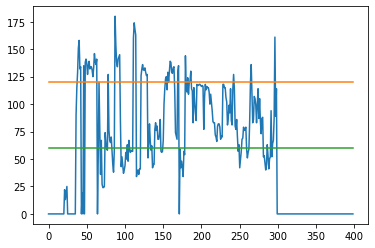

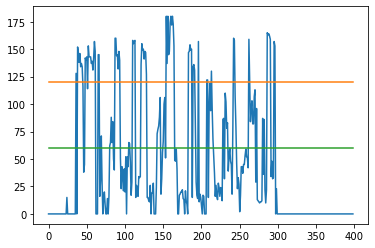

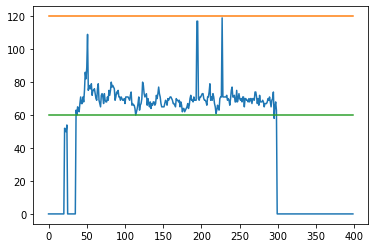

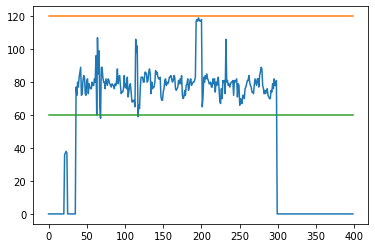

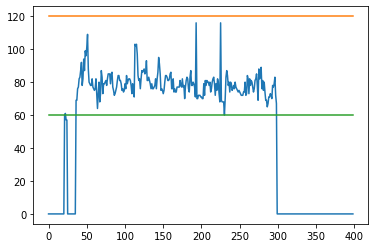

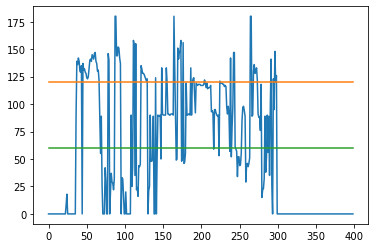

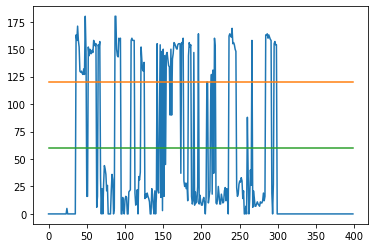

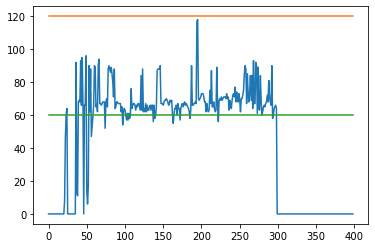

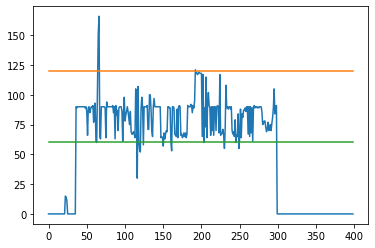

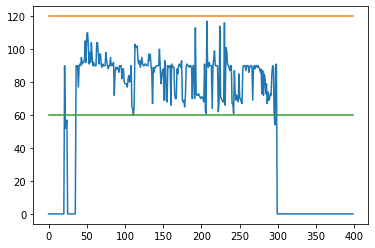

In [12]:
#tol = 5.0
dataset_dtype = "stationary"
euclid_dist=True
t60 = 0.61 #1.0
(tst, tol) = ("real", 7.5)

#(tst, tol) = ("simu", 5)
sig_list = [3]
for batch_idx in sig_list:
    print(batch_idx, "G_0.3")
    for idx in range(5):
        info = torch.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/doa_{t60}_{batch_idx}_{idx}_tol_{tol}deg_euclid_{euclid_dist}.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')

        #ref_f_doa[0]

        (mix_f_doa, mix_f_vals, mix_utt_doa) = info['mix']
        (tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa) = info['tgt']
        (est_f_doa, est_f_vals, est_utt_doa) = info['est']

        doa = info['doa']
        ref_f_doa = torch.rad2deg(doa[:,:,-1])[0,:mix_f_doa.shape[0]]

        mix_frm_Acc,_ = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(ref_f_doa),tol = tol, vad_th=0.6)
        est_frm_Acc, failed_frms = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(ref_f_doa),tol = tol, vad_th=0.6)
        
        print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
        print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

    per_file_doa(batch_idx, "G_1", tst, tol)
    per_file_doa(batch_idx, "MASK", tst, tol)

stationary 0.03745318352059925 0.352059925093633
tensor(120.0000) tensor(82.) tensor(116.)


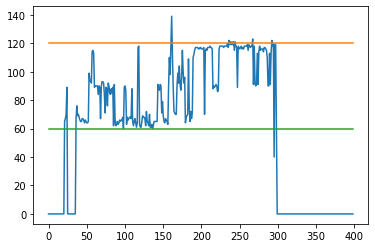

In [25]:
frame_len, frame_shift = 320, 160
batch_idx = 3
idx_list = [2] #[0,1,2,3,4]


option = "MASK"


mix_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/mix_{batch_idx}.wav')
mix_real_img = torch.stft(mix_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
mix_real_img = torch.permute(mix_real_img, [0, 3, 2, 1])

tgt_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/tgt_{batch_idx}.wav')
tgt_real_img = torch.stft(tgt_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
tgt_real_img = torch.permute(tgt_real_img, [0, 3, 2, 1])

mix_spec_cmplx = format_complex(mix_real_img)
tgt_spec_cmplx = format_complex(tgt_real_img)

##extracting 2 channels
mix_ri_spec = mix_spec_cmplx[1:3,:,:]
tgt_ri_spec = tgt_spec_cmplx[1:3,:,:]

#Vad 
vad_comp_sig = tgt_sig

sig_vad_1 = compute_vad(vad_comp_sig[0,:].cpu().numpy(), frame_len, frame_shift)
sig_vad_2 = compute_vad(vad_comp_sig[1,:].cpu().numpy(), frame_len, frame_shift)
tgt_sig_vad = sig_vad_1*sig_vad_2
tgt_sig_vad = tgt_sig_vad.to(device=tgt_sig.device)


euclid_dist=True
mix_f_doa, mix_f_vals, mix_utt_doa, _, _ = gcc_phat_loc_orient(mix_spec_cmplx, torch.abs(mix_spec_cmplx), 16000, frame_len, local_mic_pos, 
                                                                local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

wt_tgt = get_wt(option, mix_spec_cmplx, tgt_spec_cmplx) #torch.abs(tgt_spec_cmplx) #get_mask(mix_spec_cmplx, tgt_spec_cmplx) # #torch.tanh(
tgt_f_doa, tgt_f_vals, tgt_utt_doa, _, tgt_freq_vals = gcc_phat_loc_orient(tgt_spec_cmplx, wt_tgt, 16000, frame_len, local_mic_pos, 
                                                                local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

mix_frm_Acc,_ = get_acc(tgt_sig_vad, mix_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

for idx in idx_list:
    est_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/est_{batch_idx}_{idx}.wav')
    est_real_img = torch.stft(est_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
    est_real_img = torch.permute(est_real_img, [0, 3, 2, 1])

    est_spec_cmplx = format_complex(est_real_img)

    est_ri_spec = est_spec_cmplx[1:3,:,:]

    wt_est = get_wt(option, mix_spec_cmplx, est_spec_cmplx) #torch.abs(est_spec_cmplx) # get_mask(mix_spec_cmplx, est_spec_cmplx) # # torch.tanh(                                                 
    est_f_doa, est_f_vals, est_utt_doa, _, est_freq_vals = gcc_phat_loc_orient(est_spec_cmplx, wt_est, 16000, frame_len, local_mic_pos, 
                                                                    local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)
   
    est_frm_Acc, failed_frms = get_acc(tgt_sig_vad, est_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

    #Utterance level
    doa_degrees = torch.rad2deg(doa[:,:,-1])[0,0]
    mix_utt_Acc = 1 if torch.abs(mix_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa
    est_utt_Acc = 1 if torch.abs(est_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa

    print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
    print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

    plt.figure()
    plt.plot(est_f_doa)
    plt.plot(torch.abs(ref_f_doa))
    plt.plot(180-torch.abs(ref_f_doa))

In [ ]:
euclid_dist=True
mix_f_doa, mix_f_vals, mix_utt_doa, _, _ = gcc_phat_loc_orient(mix_spec_cmplx, torch.abs(mix_spec_cmplx), 16000, frame_len, local_mic_pos, 
                                                                local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

wt_tgt = torch.abs(tgt_spec_cmplx) #get_mask(mix_spec_cmplx, tgt_spec_cmplx) #torch.tanh(
tgt_f_doa, tgt_f_vals, tgt_utt_doa, _, tgt_freq_vals = gcc_phat_loc_orient(tgt_spec_cmplx, wt_tgt, 16000, frame_len, local_mic_pos, 
                                                                local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

wt_est = torch.abs(est_spec_cmplx) #get_mask(mix_spec_cmplx, est_spec_cmplx)     # torch.tanh(                                                 
est_f_doa, est_f_vals, est_utt_doa, _, est_freq_vals = gcc_phat_loc_orient(est_spec_cmplx, wt_est, 16000, frame_len, local_mic_pos, 
                                                                local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)


mix_frm_Acc,_ = get_acc(tgt_sig_vad, mix_f_doa, ref_f_doa, tol=tol, vad_th=0.6)
est_frm_Acc, failed_frms = get_acc(tgt_sig_vad, est_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

#Utterance level
doa_degrees = torch.rad2deg(doa[:,:,-1])[0,0]
mix_utt_Acc = 1 if torch.abs(mix_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa
est_utt_Acc = 1 if torch.abs(est_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa

print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

In [ ]:
frm = 135
plt.plot(est_f_vals[:,frm])

In [ ]:
plt.plot(est_f_doa)
plt.plot(ref_f_doa)

#
\gamma = 1 \
stationary 0.19946091644204852 0.18598382749326145 \
tensor(75.) tensor(86.) tensor(78.) \
stationary 0.19946091644204852 0.20485175202156333 \
tensor(75.) tensor(86.) tensor(78.) \
stationary 0.19946091644204852 0.6361185983827493 \
tensor(75.) tensor(86.) tensor(73.) \
stationary 0.19946091644204852 0.7520215633423181 \
tensor(75.) tensor(86.) tensor(73.) \
stationary 0.19946091644204852 0.5902964959568733 \
tensor(75.) tensor(86.) tensor(74.) 

#
\gamma = 0.3
stationary 0.16981132075471697 0.16711590296495957 \
tensor(75.) tensor(85.) tensor(84.) \
stationary 0.16981132075471697 0.2830188679245283 \
tensor(75.) tensor(85.) tensor(76.) \
stationary 0.16981132075471697 0.6199460916442049 \
tensor(75.) tensor(85.) tensor(73.) \
stationary 0.16981132075471697 0.3584905660377358 \
tensor(75.) tensor(85.) tensor(74.) \
stationary 0.16981132075471697 0.16442048517520216 \
tensor(75.) tensor(85.) tensor(75.)